<a href="https://colab.research.google.com/github/AlexandruPascu/data_processing/blob/main/MSM_Faraday_Battery_Data_Importer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The below code downloads a zip file from a GitHub repository that contains **examples of battery cycling data. These can be used to test and explore the battery data analysis functions in this notebook.**

*Note that this code assumes that the current working directory is /content/, so specific file paths used in this code may need to be adjusted based on the user's directory structure accordingly if needed. It also assumes the notebook is running on a Linux or Mac environment with wget and unzip installed. wget and unzip may need to be installed or the code may need to be modified to work with the Windows equivalents of these tools.*

--2024-01-22 08:36:55--  https://github.com/AlexandruPascu/WMG-Data-Importer-Faraday-MSM/archive/refs/heads/main.zip
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/AlexandruPascu/WMG-Data-Importer-Faraday-MSM/zip/refs/heads/main [following]
--2024-01-22 08:36:55--  https://codeload.github.com/AlexandruPascu/WMG-Data-Importer-Faraday-MSM/zip/refs/heads/main
Resolving codeload.github.com (codeload.github.com)... 140.82.121.10
Connecting to codeload.github.com (codeload.github.com)|140.82.121.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘main.zip’

main.zip                [     <=>            ]   3.92M  4.48MB/s    in 0.9s    

2024-01-22 08:36:57 (4.48 MB/s) - ‘main.zip’ saved [4113966]



In [5]:
!wget https://github.com/AlexandruPascu/WMG-Data-Importer-Faraday-MSM/archive/refs/heads/main.zip || exit 1
!unzip -q main.zip -d example_cyclers || exit 1
!mv ./example_cyclers/WMG-Data-Importer-Faraday-MSM-main/data_examples ./cyclers_examples || exit 1
!rm main.zip
!rm -r ./example_cyclers

--2024-01-22 08:41:19--  https://github.com/AlexandruPascu/WMG-Data-Importer-Faraday-MSM/archive/refs/heads/main.zip
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/AlexandruPascu/WMG-Data-Importer-Faraday-MSM/zip/refs/heads/main [following]
--2024-01-22 08:41:20--  https://codeload.github.com/AlexandruPascu/WMG-Data-Importer-Faraday-MSM/zip/refs/heads/main
Resolving codeload.github.com (codeload.github.com)... 140.82.121.9
Connecting to codeload.github.com (codeload.github.com)|140.82.121.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘main.zip’

main.zip                [    <=>             ]   3.92M  5.67MB/s    in 0.7s    

2024-01-22 08:41:21 (5.67 MB/s) - ‘main.zip’ saved [4113966]



This section imports the necessary Python libraries for the data processing and visualization that will be performed later in the notebook.

*   re is used for regular expressions, which can be useful for string matching and manipulation.
*   os provides a way to interact with the operating system, such as navigating directories and accessing files.
*   sys provides access to some variables used or maintained by the interpreter and to functions that interact strongly with the interpreter.
*   chardet is used to detect the character encoding of a file.
*   openpyxl is a library for working with Excel files.
*   csv provides functionality for working with CSV (Comma-Separated Values) files.
*   math provides mathematical functions and constants.
*   numpy is a library for numerical computations with Python, providing efficient implementations of arrays and matrices.
*   pandas is a library for data manipulation and analysis, offering data structures and operations for manipulating numerical tables and time series.
*   matplotlib is a plotting library that allows users to create a wide range of visualizations.

*Make sure to install these libraries before running the code if needed.*

In [ ]:
# If you get an error from the below code block it means that you need to 
# install some libraries, therefore remove the hashtag and the space from those 
# that you need or all of them if you cannot tell
# !pip install chardet
# !pip install openpyxl
# !pip install numpy
# !pip install pandas
# !pip install matplotlib

In [6]:
import re
import os
import sys

import chardet
import openpyxl
import csv
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

/var/folders/p_/zsbr7_r56_77g5wsfkx99sqm0000gn/T/ipykernel_51973/2294924152.py:11: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


This section of the notebook includes various custom functions that are designed to manipulate battery cyclers data, analyze and visualize it. Here is a brief overview of what each function does:

*   **look_for_files**(path_or_file: str): This function searches for files in the specified path or file and returns a list of file paths.
*   **convert_xlsx_to_csv**(file_path: str): This function converts an Excel file to a CSV file.
*   **find_words**(file_path: str, cycler_keywords: dict) -> tuple: This function searches for specified keywords in a file and returns the pointer location where the keyword was found and the file encoding.
*   **split_file**(pointer: int, file_path: str, save_option: str) -> tuple: This function splits a file at a specified pointer and saves if wanted the resulting files (metadata and data separately) according to the specified save option.
*   **read_data_to_pandas**(data, filepath: str, encoding: str) -> pd.DataFrame: This function reads data from the file containing only the data and not the metadata file and returns a Pandas DataFrame.
*   **change_units**(df: pd.DataFrame, standard_units: dict, standard_time: list) -> pd.DataFrame: This function converts the units of the specified columns in a DataFrame to standardize units format.
*   **change_headers**(df: pd.DataFrame, standard_headers: dict) -> pd.DataFrame: This function renames the headers of the specified columns in a DataFrame to standardize headers format.
*   **add_state_label**(df: pd.DataFrame, current_epsilon: float = 0.0005, voltage_epsilon: float = 0.0005, time_threshold: int = 15) -> pd.DataFrame: This function adds a state labels to a DataFrame based on the specified voltage and current epsilon and time threshold for Charging/Discharging/Rest and CCCV with the corresponding approximate values.
*   **segment_df**(df: pd.DataFrame, request: str) -> list: This function returns a list of dataframes segmented by a given request string such as constant currents, constant voltages, CCCV, charging, discharging, rest
*   **find_cccv_periods**(df): This function finds periods of constant current constant voltage (CCCV) in a given dataframe.
*   **plot_current_voltage_diff**(df) -> None: This function plots the derivative (differences between consecutive values) of the current and voltage columns over their normal values in a DataFrame.
*   **display_data**(df: pd.DataFrame) -> None: This function displays a preview of the DataFrame in a text format and plots for Current, Voltage, Step and Temperature over Time.
*   **save_file**(df: pd.DataFrame, file_path: str): This function saves a Pandas dataframe to a CSV file in a subfolder of the directory containing the input file.

*Make sure to understand the purpose of each function before using it in your analysis, and make sure to specify the correct arguments when calling each function.*

In [7]:
def look_for_files(path_or_file: str):
    """Find files in a directory or return a file path.

    Args:
        path_or_file (str): A path to a file or directory.
    Returns:
        List[str]: A list of file paths.
    Raises:
        ValueError: If the provided path does not exist, or if a file is empty.
    """

    if os.path.isfile(path_or_file):
        # If a file is provided and not empty, return the file
        if os.path.getsize(path_or_file) > 1:
            return [path_or_file]
        else:
            raise ValueError(f"Empty file: {path_or_file}")
    elif os.path.isdir(path_or_file):
        # If a directory is provided, scan the directory for files
        files = [os.path.join(path_or_file, f) for f in os.listdir(path_or_file)
        if os.path.isfile(os.path.join(path_or_file, f)) and 
        os.path.getsize(os.path.join(path_or_file, f))]

        if not files:
            raise ValueError(f"No files found in the directory: {path_or_file}")
        return files
    else:
        # If the provided path does not exist
        raise ValueError(f"Invalid path or file: {path_or_file}")

def convert_xlsx_to_csv(file_path: str):
    """Converts an Excel file to a CSV file.

    Args:
        file_path (str): The path to the Excel file.
    Returns:
        str: The path to the converted CSV file.
    """

    # Load the workbook
    workbook = openpyxl.load_workbook(file_path)
    # Get the active sheet
    sheet = workbook.active

    # Create a temporary csv file
    current_dir = os.path.dirname(file_path)
    csv_file_path = os.path.join(current_dir, 'converted_temporary.csv')
    
    with open(csv_file_path, 'w', newline='') as csv_file:
        writer = csv.writer(csv_file)
        # Write each row in the sheet to the csv file
        for row in sheet.iter_rows(values_only=True):
            writer.writerow(row)

    return csv_file_path

def find_words(file_path: str, cycler_keywords: dict) -> tuple:
    """Searches for keywords in a file.

    Args:
        file_path (str): The path to the file to search for keywords.
        cycler_keywords (dict): A dictionary containing the keywords to be 
                                search for.
    Returns:
        tuple: A tuple containing the byte location of the match and the file 
                encoding.
    Raises:
        ValueError: If no keywords are found in the file or there is something
                    wrong with the input file.
    """
    
    # Check if the file is xlsx
    if file_path.endswith('.xlsx'):
        file_path = convert_xlsx_to_csv(file_path)

    with open(file_path, 'rb') as f:
        # Read the contents of the file and detect the encoding
        contents = f.read()
        encoding = chardet.detect(contents)['encoding']
        if encoding is None:
            raise ValueError("Something is wrong with your input file")
        else:
            contents = contents.decode(encoding)

    # Compile the regular expression pattern
    data = []
    for value in cycler_keywords.values():
        data.extend([rf"\s*{re.escape(word)}\s*" for word in value])
    pattern = re.compile('|'.join(data))

    # Search for the keywords in the file
    match = pattern.search(contents)
    if match:
        with open(file_path, 'rb') as f:
            # If a match is found, set the pointer to the location of the match
            f.seek(match.start())
            return (f.tell(), encoding)
    else:
        # If no match is found, raise an exception
        raise ValueError(f"No keywords found in file: {file_path}")
    
def split_file(pointer: int, file_path: str, save_option: str) -> tuple:
    """Split a file into two parts at a given pointer.
    
    Args:
        pointer (int): The byte position where the file should be split.
        file_path (str): The path to the file to be split.
        save_option (str): An option to specify how to save the split files.
            'save all': Save both parts to a new subfolder named 
            'pre_processed'.
    Returns:
        tuple: A tuple containing the two parts of the split file.
    """

    name = file_path

    # Check if the file is xlsx
    if file_path.endswith('.xlsx'):
        file_path = os.path.dirname(file_path) + '/converted_temporary.csv'

    with open(file_path, 'rb') as f:
        contents = f.read()
        # Split the file into two parts
        metadata = contents[:pointer]
        data = contents[pointer:]

    if save_option == 'save all':
        # Get the current directory of the file
        current_dir = os.path.dirname(name)
        # Extract the file name and extension from the input file path
        file_name, file_ext = os.path.splitext(os.path.basename(name))

        # Create a subfolder if it doesn't exist
        output_dir = os.path.join(current_dir, 'pre_processed')
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)

        # Save the first part to a text file in the output directory
        new_file_name = file_name + '_metadata.txt'
        output_path = os.path.join(output_dir, new_file_name)
        with open(output_path, 'wb') as f:
            f.write(metadata)

        # Save the second part to the new file with the original file format in
        # the output directory
        new_file_name = file_name + '_data' + file_ext
        output_path = os.path.join(output_dir, new_file_name)
        with open(output_path, 'wb') as f:
            f.write(data)

        if 'converted_temporary.csv' in os.path.basename(file_path):
            os.remove(file_path)
        return (metadata, data)

    else:
        if 'converted_temporary.csv' in os.path.basename(file_path):
            os.remove(file_path)
        return (metadata, data)

def read_data_to_pandas(data, filepath: str, encoding: str) -> pd.DataFrame:
    """Reads a file to a Pandas DataFrame.

    Args:
        data: bytes, the contents of the file to be read.
        filepath: str, the path of the file to be read.
        encoding: str, the encoding of the file.
    Returns:
        A pandas.DataFrame object containing the data from the file.
    Raises:
        ValueError: if the file format is invalid.
    """

    # Write data to a temporary file
    temp_file = 'new_file_name'
    with open(temp_file, 'wb') as f:
        f.write(data)
        
    # Determine file extension
    file_ext = os.path.splitext(filepath)[1]

    # Read file using the appropriate Pandas function based on its extension
    if file_ext == '.csv':
        df = pd.read_csv(temp_file, encoding=encoding)
    elif file_ext == '.xlsx':
        df = pd.read_csv(temp_file, encoding = encoding)
    elif file_ext == '.txt':
        df = pd.read_csv(temp_file, sep = '\t', encoding=encoding)
    elif file_ext == '.mpt':
        df = pd.read_table(temp_file, encoding=encoding)
    elif file_ext == '.DTA':
        df = pd.read_table(temp_file, sep = '\t', encoding=encoding)
    else:
        os.remove(temp_file)
        raise ValueError(f"Invalid file format: {file_ext}")

    # Remove the temporary file
    os.remove(temp_file)
    
    return df

def change_units(df: pd.DataFrame,
                 standard_units: dict,
                 standard_time: list) -> pd.DataFrame:
    """Change the units of a pandas DataFrame's columns to the standard units
    remove the first row

    Args:
        df (pd.DataFrame): The DataFrame whose column units are to be changed.
        standard_units (dict): A dictionary that maps column names to standard
                                unit multipliers.
        standard_time (list): A list of column names that represent time. 
    Returns:
        pd.DataFrame: A copy of the input DataFrame with columns converted to
                        standard units.
    """

    for col in df.columns:
        if col in standard_units:
            df[col] = df[col] * standard_units[col]
        elif col in standard_time:
            if col == 'Run Time (h)':
                df[col] = df[col] * 3600
            else:
                # Convert a string representing a time duration to seconds
                time_delta = pd.to_timedelta(df[col])
                df[col] = time_delta.dt.total_seconds()
    df = df.iloc[1:]
    return df

def change_headers(df: pd.DataFrame, standard_headers: dict) -> pd.DataFrame:
    """Renames and converts columns in a Pandas DataFrame based on a given 
    mapping.

    Args:
        df (pandas.DataFrame): The DataFrame whose headers will be changed.
        standard_headers (dict): A dictionary with the original column names as 
                                keys and lists of possible new column names as
                                values.
    Returns:
        pandas.DataFrame: The updated DataFrame with new column names and
                            converted data types.
    """

    # Get the original column names
    original_headers = df.columns
    # Create a dictionary to store the new header names
    new_headers = {}

    for col in original_headers:
        for header, value in standard_headers.items():
            # Check if the original header matches the mapping
            if col in value:
                new_headers[col] = header
                break

    # Rename columns using the new mapping
    df.rename(columns=new_headers, inplace=True)

    # Convert columns with new headers to numeric data types
    for col in df.columns:
        if col in standard_headers:
            df[col] = pd.to_numeric(df[col], errors = 'coerce')

    return df

def add_state_label(df: pd.DataFrame,
                    current_epsilon: float = 0.0005,
                    voltage_epsilon: float = 0.0005,
                    time_threshold: int = 15) -> pd.DataFrame:
    """Adds battery state and CCCV columns to a given DataFrame.
    The function takes a DataFrame with at least the following columns:
        - 'Current [A]': battery current in amperes
        - 'Voltage Full [V]': battery voltage in volts
        - 'Time [s]': time in seconds
    It calculates the battery state (rest, charging, discharging) and the CCCV
    (CC, CV, N/A) for each row and returns the updated DataFrame.

    Args:
        df: A pandas DataFrame with battery data.
        current_epsilon: The threshold to consider current as zero.
        voltage_epsilon: The threshold to consider voltage as constant.
        time_threshold: The minimum duration in seconds for a constant voltage 
            or constant current interval to be considered.
    Returns:
        A pandas DataFrame with additional 'Battery State', 'CCCV',
        'CCCV [A][V]', and 'Charging / Discharging [A]' columns.
    """

    # Check if required columns are present in dataframe
    required_cols = ['Current [A]', 'Voltage Full [V]', 'Time [s]']
    for col in required_cols:
        if col not in df.columns:
            raise ValueError(f"{col}, required column not found in dataframe")

    # Set initial state label to "unknown" for all rows
    df['Battery State'] = 'unknown'
    df['CCCV'] = 'N/A'  # Initialize CCCV column to 'N/A'
    df['CCCV [A][V]'] = np.nan

    # Define masks for each state
    rest_mask = df['Current [A]'].abs().lt(current_epsilon)
    charging_mask = df['Current [A]'].gt(current_epsilon)
    discharging_mask = df['Current [A]'].lt(-current_epsilon)

    # Assign labels for each state
    df.loc[rest_mask, 'Battery State'] = 'rest'
    df.loc[charging_mask, 'Battery State'] = 'charging'
    df.loc[discharging_mask, 'Battery State'] = 'discharging'

    # Group rows with constant voltages values
    cv_intervals = df.groupby((df['Voltage Full [V]'] - df['Voltage Full [V]'].shift()).abs().gt(voltage_epsilon).cumsum())

    # Loop over each constant voltage interval and update columns
    for _, group in cv_intervals:
        if group['Time [s]'].iloc[-1] - group['Time [s]'].iloc[0] >= time_threshold:
            cv_value = round(group['Voltage Full [V]'], 2)
            group_indices = group.index.tolist()
            df.loc[group_indices, 'CCCV'] = 'CV'
            df.loc[group_indices, 'CCCV [A][V]'] = cv_value

    # Group rows with constant current values
    # not_rest_mask = df['Battery State'] != 'rest'
    cc_intervals = df[~rest_mask].groupby((df[~rest_mask]['Current [A]'] -
                                           df[~rest_mask]['Current [A]'].shift()
                                           ).abs().gt(current_epsilon).cumsum())
    df['Chg / Dchg [A]'] = df.loc[~rest_mask, 'Current [A]'].round(2)

    # Loop over each constant current interval and update columns
    for cc, group in cc_intervals:
        if group['Time [s]'].iloc[-1] - group['Time [s]'].iloc[0] >= time_threshold:
            cc_value = round(group['Current [A]'], 2)
            group_indices = group.index.tolist()
            df.loc[group_indices, 'CCCV'] = 'CC'
            df.loc[group_indices, 'CCCV [A][V]'] = cc_value

    return df

def segment_df(df: pd.DataFrame, request: str) -> list:
    """Returns a list of dataframes segmented by a given request string such as
    constant currents, constant voltages, CCCV, charging, discharging, rest
    
    Args:
        df: A pandas DataFrame with battery data.
        request: A string containing the segmentation request
    Returns:
        A list of pandas DataFrames, where each DataFrame corresponds to a
        segment of the original DataFrame based on the specified request.
    Raises:
        ValueError: If the required columns are not found in the input dataframe
    """
    
    # Check if request can be performed
    required_cols = ['Current [A]', 'Voltage [V]', 'Time [s]']
    if not any(col in df.columns for col in required_cols):
        raise ValueError(f"Action cannot be performed because {col}, required column not found in dataframe")

    # Check if required columns are present in dataframe
    required_cols = ['Battery State', 'CCCV', 'CCCV [A][V]', 'Chg / Dchg [A]']
    if not any(col in df.columns for col in required_cols):
        df = add_state_label(df)

    # Create a list of dataframes for each segment
    df_list = []

    # Define masks for each state
    rest_mask = df['Battery State'] == 'rest'
    chg_mask = df['Battery State'] == 'charging'
    dchg_mask = df['Battery State'] == 'discharging'
    CC_mask = df['CCCV'] == 'CC'
    CV_mask = df['CCCV'] == 'CV'

    # Create a list of dataframes with the corresponding request
    if 'rest' in request:
        # Segment based on rest state
        df_list += [df[rest_mask]]
    if 'chg' in request:
        # Segment based on charging state
        chg_request = request.split('chg')[1].split(',')[0]
        if 'A' in chg_request:
            # Segment based on charging current
            chg_A = float(chg_request.split('A')[0])
            df_list += [df[chg_mask & (df['Chg / Dchg [A]'] == chg_A)]]
        else:
            # Segment all charging periods
            df_list += [df[chg_mask]]
    if 'dchg' in request:
        # Segment based on discharging state
        dchg_request = request.split('dchg')[1].split(',')[0]
        if 'A' in dchg_request:
            # Segment based on discharging current
            dchg_A = float(dchg_request.split('A')[0])
            df_list += [df[dchg_mask & (df['Chg / Dchg [A]'] == dchg_A)]]
        else:
            # Segment all discharging periods
            df_list += [df[dchg_mask]]
    if 'const curr' in request:
        # Segment based on constant current state
        CC_request = request.split('const curr')[1].split(',')[0]
        if 'A' in CC_request:
            # Segment based on constant current value
            CC_A = float(CC_request.split('A')[0])
            df_list += [df[CC_mask & (df['CCCV [A][V]'] == CC_A)]]
        else:
            # Segment all constant current periods
            df_list += [df[CC_mask]]
    if 'const voltage' in request:
        # Segment based on constant voltage state
        CV_request = request.split('const voltage')[1].split(',')[0]
        if 'V' in CV_request:
            CV_V = float(CV_request.split('V')[0])
            df_list += [df[CV_mask & (df['CCCV [A][V]'] == CV_V)]]
        else:
            # Segment all constant voltage periods
            df_list += [df[CV_mask]]
    if 'CCCV' in request:
        # Segment based on CCCV state
        df_list += find_cccv_periods(df)
           
    return df_list

def find_cccv_periods(df):
    """Finds periods of constant current constant voltage (CCCV) in a given
    dataframe.

    Args:
        df (pd.DataFrame): A dataframe with columns 'Battery State', 'CCCV',
        'CCCV [A][V]', 'Chg / Dchg [A]'.
    Returns:
        list: A list of dataframes, where each dataframe corresponds to a CCCV
        period.
    """

    # Initialize variables
    start_time = None
    end_time = None
    in_cccv = False
    cccv_periods = []

    # Drop rows where 'CCCV [A][V]' is empty
    df = df.dropna(subset=['CCCV [A][V]'])

    # Iterate over dataframe rows
    for i, row in df.iterrows():
        # Check if current row is in CCCV state
        if row['CCCV'] == 'CC' and row['Battery State'] == 'charging':
            # Check if CCCV period has already started
            if not in_cccv:
                start_time = row['Time [s]']
                in_cccv = True
        elif row['CCCV'] == 'CV':
            # Check if CCCV period is ending
            if in_cccv and row['Time [s]'] < df.tail(1)['Time [s]'].values[0]:
                if row['Battery State'] != 'charging':
                    end_time = row['Time [s]']
                    cccv_periods.append(df[(df['Time [s]'] >= start_time) &
                                           (df['Time [s]'] < end_time)])
                    in_cccv = False
        else:
            # Reset variables if not in CCCV state
            start_time = None
            end_time = None
            in_cccv = False

    return cccv_periods

def plot_current_voltage_diff(df) -> None:
    """Plots the current and voltage of a dataframe, along with the differences 
    between consecutive values.

    Args:
        df (pandas.DataFrame): The input dataframe with the columns
        'Current [A]', 'Voltage Full [V]', and 'Time [s]'.
    Raises:
        ValueError: If any of the required columns are missing from the input
        dataframe.
    """

    # Check if required columns are present in dataframe
    required_cols = ['Current [A]', 'Voltage Full [V]', 'Time [s]']
    for col in required_cols:
        if col not in df.columns:
            raise ValueError(f"{col} column not found in dataframe")
    
    # Compute difference between consecutive elements for Current and Voltage
    diff_current = df['Current [A]'].diff()
    diff_voltage = df['Voltage Full [V]'].diff()
    
    # Plot current on time with diff layered on top
    fig, ax = plt.subplots()
    ax.plot(df['Time [s]'], df['Current [A]'], label = 'Current')
    ax.plot(df['Time [s]'], diff_current, label='Current Diff')
    ax.set_xlabel('Time [s]')
    ax.set_ylabel('Current [A]')
    ax.legend()
    plt.show()
    
    # Plot voltage on time with diff layered on top
    fig, ax = plt.subplots()
    ax.plot(df['Time [s]'], df['Voltage Full [V]'], label = 'Voltage')
    ax.plot(df['Time [s]'], diff_voltage, label = 'Voltage Diff')
    ax.set_xlabel('Time [s]')
    ax.set_ylabel('Voltage Full [V]')
    ax.legend()
    plt.show()

def display_data(df: pd.DataFrame) -> None:
    """Display a grid of subplots of the Current, Voltage, Step Number and 
    Temperature columns in the dataframe.

    Args:
        df: A pandas dataframe containing the data to be displayed.
    Raises:
        ValueError: If none of the required columns are present in the dataframe
        or if the time column is not present in the dataframe.
    """

    print(df.head(10))

    # Check if at least one required column is present
    required_cols = ['Current [A]', 'Voltage Full [V]', 'Step Number',
                     'Temperature [degC]']
    if not any(col in df.columns for col in required_cols):
        raise ValueError("None of the required columns are present")

    # Check if the time column is present
    if 'Time [s]' not in df.columns:
        raise ValueError("Time [s] column is not present in the dataframe")

    # Set the index to the time column
    df.set_index('Time [s]', inplace = False)

    # Check if dataframe has required columns
    missing_cols = [col for col in required_cols if col not in df.columns]

    # Remove missing columns from required_cols
    required_cols = [col for col in required_cols if col in df.columns]

    # Create a grid of subplots
    n_cols = len(required_cols) % 3 + math.floor(len(required_cols) / 3)
    n_rows = math.ceil(len(required_cols) / n_cols)
    fig, axs = plt.subplots(n_rows, n_cols, sharex = True, squeeze = False)

    # Plot the data on each subplot
    for i, col in enumerate(required_cols):
        if col in df.columns:
            col_idx = i % n_cols
            row_idx = i // n_cols
            df[col].plot(ax=axs[row_idx][col_idx])
            axs[row_idx][col_idx].set_ylabel(col)

    # Add a common x-axis label
    fig.add_subplot(111, frameon=False)
    plt.tick_params(labelcolor = 'none', top = False, bottom = False,
                    left = False, right = False)
    plt.xlabel('Time [s]')

    # Show the plot
    plt.show()

def save_file(df: pd.DataFrame, file_path: str):
    """Saves a Pandas dataframe to a CSV file in a subfolder of the directory
    containing the input file.

    Args:
        df: A Pandas dataframe to be saved to a file.
        file_path: A string representing the path of the input file.
    Returns:
        str: The path to the saved CSV file from the pandas dataframe.
    """

    # Get the directory containing the input file
    current_dir = os.path.dirname(file_path)
    
    # Create a subdirectory to store the output file
    output_dir = os.path.join(current_dir, 'processed')
    os.makedirs(output_dir, exist_ok = True)

    # Extract the file name and extension from the input file path
    file_name, file_ext = os.path.splitext(os.path.basename(file_path))
    
    # Save the dataframe to a CSV file in the output directory
    new_file_name = f"{file_name}_cleaned_data.csv"
    output_path = os.path.join(output_dir, new_file_name)
    df.to_csv(output_path, index = False)

    return output_path

The data_importer function is the main function of the notebook. This function is the backbone of the data processing in the notebook, and it allows the user to easily import and process data from different types of files with various options. The function takes the following arguments:

*   **path_or_file**: The file path or name to read data from.
*   **save_option**: Option to choose saving files or display data. It defaults to 'save'.
*   **state_option**: Option to add state labels to the data. It defaults to an empty string.
*   **print_option**: Option to print the dataframe and the 4 plots. It defaults to an empty string.
*   **cycler_keywords**: Dictionary containing header row options to terminate meta info for various types of data files. It defaults to a precompiled dictionary with keywords collected from multiple cycler machines.
*   **standard_units**: Dictionary of units to be converted to standard units. It defaults to a dictionary with standardize units according to the usual battery conventions.
*   **standard_time**: List of time-related columns. It defaults to a list of times we noticed are not set in seconds by default.
*   **standard_headers**: Dictionary of standard header names to replace original headers. It defaults to a dictionary with standardize headers according to the pybamm library.

The function processes each file found in the given *path_or_file*. It uses helper functions to find the metadata and data in the file, split the file, read the data into a pandas dataframe, change the units, and change the headers. If *state_option* is set to 'yes', it adds state labels to the data.

If *save_option* is set to 'save all' or 'save', the function saves the file. If *print_option* is set to 'yes' or 'all', the function prints the dataframe and the 4 plots. If *print_option* is set to 'all', it also prints the difference on current and voltage.

*The function also has error handling to catch any errors that may occur while processing the data, and it prints out the error and the file name where the error occurred.*

In [8]:
def data_importer(path_or_file: str,
                  save_option: str = 'save',
                  state_option: str = '',
                  print_option: str = '',
                  cycler_keywords: dict = {},
                  standard_units: dict = {},
                  standard_time: list = [],
                  standard_headers: dict = {}) -> None:
    """Imports data from files based on given file path and options.

    Args:
        path_or_file (str): The file path or name to read data from.
        option (str, optional): Option to choose saving files or display data.
        cycler_keywords (dict, optional): Dictionary containing header row 
            options to terminate meta info for various types of data files.
        standard_units (dict, optional): Dictionary of units to be converted to
            standard units.
        standard_time (list, optional): List of time-related columns.
        standard_headers (dict, optional): Dictionary of standard header names 
            to replace original headers.
    """

    # Data header row options to terminate meta info. NOTE: enter unique names
    # provided by the cycler and not generic e.g. "TestTime" instead of "time"
    cycler_keywords = {
        "maccor": ["Cyc#", "Rec#", "TestTime"],
        "vmp3": ["mode", "(Q-Qo)/mA.h", "freq/Hz", "time/s", "Ecell/V"],
        "bitrode": ["Exclude", "Total Time", "Loop Counter#1", "Amp-Hours"],
        "digatron": ["Step,", "AhAccu", "Prog Time"],
        "ivium": ["freq. /Hz", "Z1 /ohm"],
        "gamry": ["Pt\tT", "IERange"],
        "solatron": ["Time (s)", "Z' (Ohm)"],
        "novonix": ["Potential (V)", "Cycle Number"]
    } if bool(cycler_keywords) is False else cycler_keywords

    # Define the standard time columns
    standard_time = [
        "Total Time, (h:m:s)",
        "Run Time (h)",
        "TestTime"
    ] if len(standard_time) == 0 else standard_time

    # Define the standard units
    standard_units = {
        "<I>/mA": 1E+3,
        "(Q-Qo)/mA.h": 1E+3,
    } if bool(standard_units) is False else standard_units

    # Map key header variables to a standardized variable
    standard_headers = {
        "Current [A]": ["Current, A", "Current", "Im", "Amps", " Current (A)",
                        "Current (A)", "<I>/mA", "I/mA"],
        "Voltage Full [V]": ["Voltage, V", "Voltage", "Vf", "Volts",
                             "Voltage [V]", "Potential (V)", "Ewe-Ece/V",
                             "Ecell/V", "Voltage (V)", "Voltage (V)"],
        "Voltage We [V]": ["Ewe/V"],
        "Voltage Ce [V]": ["Ece/V"],
        "AmpHrs [Ah]": ["Amp-Hours, AH", "Amp-Hours", "AhAccu", "Amp-hr",
                        "Cap. [Ah]", "Capacity (Ah)", "Charge (C)",
                        "(Q-Qo)/mA.h", "Charge (C)"],
        "WattHrs [Wh]": ["Watt-Hours, WH", "Watt-Hours", "WhAccu", "Watt-hr",
                         "Ener. [Wh]", "Energy (Wh)"],
        "Temperature [degC]": ["Temperature A1", "LogTemp001", "Temp", "Temp 1",
                               "Temperature (°C)", "LogTemp0130102", "Aux #1"],
        "Step Number": ["Step", "Step Number", "cycle number"],
        "freq [Hz]": ["freq. /Hz", "Frequency (Hz)", "freq/Hz",
                      "Frequency (Hz)"],
        "ReZ [Ohm]": ["Z1 /ohm", "Z' (Ohm)", "Re(Z)/Ohm", "Z' (Ohm)"],
        "ImZ [Ohm]": ["Z2 /ohm", "Z'' (Ohm)", "Im(Z)/Ohm", "Z'' (Ohm)"],
        "magZ [Ohm]": ["| Z | (Ohm)", "|Z|/Ohm"],
        "phaseZ [deg]": ["Phase (Deg)", "Phase(Z)/deg"],
        "Cycle Number": ["Cyc#", "Cycle Number", "cycle number"],
        "Time [s]": ["TestTime", "TestTime(s)", "time/s", "Total Time, (h:m:s)",
                    "Total Time", "Prog Time", "T", "Time (s)", "Run Time (h)",
                    "Time (s)"]
    } if bool(standard_headers) is False else standard_headers

    # Process each file
    for file in look_for_files(path_or_file):
        pointer, encoding = find_words(file, cycler_keywords)
        metadata, data = split_file(pointer, file, save_option)
        df = read_data_to_pandas(data, file, encoding)
        df = change_units(df, standard_units, standard_time)
        df = change_headers(df, standard_headers)

        if state_option == 'yes':
            try:
                df = add_state_label(df)
            except Exception as e:
                print(f"An error occurred: {e} in file {file}")

        # Save the file if the option is set to 'save all' or 'save'
        if save_option in ['save all', 'save']:
            save_file(df, file)

        # Print the dataframe and the 4 plots if print_option is 'yes
        if print_option in ['yes', 'all']:
            try:
                display_data(df)
            except Exception as e:
                print(f"An error occurred: {e} in file {file}")

        # Print the diff on current and voltage
        if print_option == 'all':
            try:
                plot_current_voltage_diff(df)
            except Exception as e:
                print(f"An error occurred: {e} in file {file}")

By calling data_importe with the path to the directory containing the example data files, the function will process each file in the directory and apply the desired data processing and output options to all the files available(in this case only saving pre-proccesed battery from the original files without the battery labels or the plots). The resulting data can then be used for further analysis or visualization in the notebook.

In [10]:
data_importer(path_or_file = './cyclers_examples')

/var/folders/p_/zsbr7_r56_77g5wsfkx99sqm0000gn/T/ipykernel_51973/2499999807.py:183: DtypeWarning: Columns (0,2,3,4,5,7,8,9,10,11,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(temp_file, encoding=encoding)


Alternatively here is an example for just one file from the examples but which also saves the metadata and the raw data, adds the battery state labels, plots the CCCV and then finaly prints the data and displays the 4 plots

<ipython-input-31-6260f5a4641d>:183: DtypeWarning: Columns (0,2,3,4,5,7,8,9,10,11,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(temp_file, encoding=encoding)


    Step Number Status Step Time  Time [s] Cycle Cycle Level  \
1             1    ...     0.000     0.000     0           0   
2             1    PAU     0.059     0.359     0           0   
3             1    PAU     0.059     0.359     0           0   
4             1    PAU     1.190     1.490     0           0   
5             1    PAU     2.159     2.459     0           0   
6             1    PAU     3.161     3.461     0           0   
7             1    PAU     4.155     4.455     0           0   
8             1    PAU     5.198     5.498     0           0   
9             1    PAU     6.152     6.452     0           0   
10            1    PAU     7.188     7.488     0           0   

               Procedure  Voltage Full [V]  Current [A]  AmpHrs [Ah]   AhPrev  \
1        LTA_RPT_Cycling           0.00000          0.0          NaN      NaN   
2   LTA_LG50_RPT_Cycling           4.13938          0.0          NaN      NaN   
3   LTA_LG50_RPT_Cycling           4.13938          

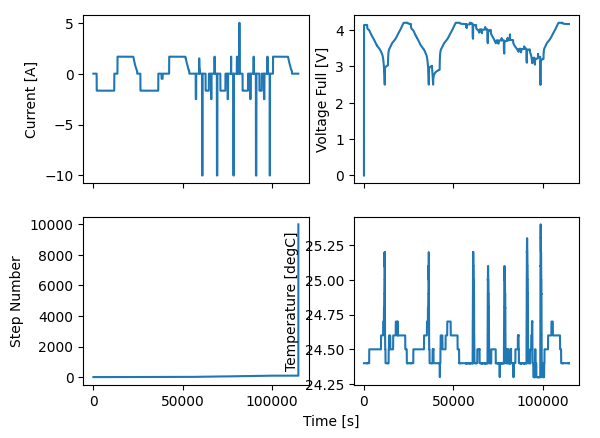

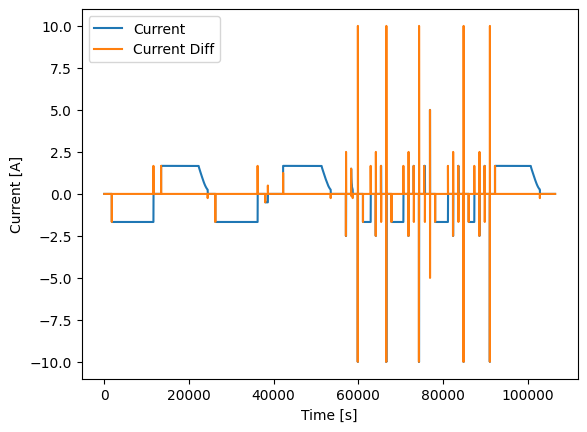

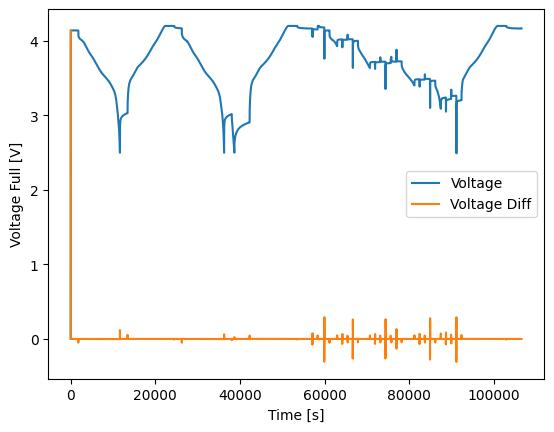

In [ ]:
data_importer(path_or_file = '/content/cyclers_examples/Cell033_RPT_0p3C_0p3C_100_0_80cyc_10degC.csv', state_option = 'yes', print_option = 'all', save_option = 'save all')

This code block reads in a CSV file with the **cleaned labeled cycler data** processed above (make sure to **edit the file location** accordingly with your usecase and firstly run the **data_importer on the raw file with the state_option as yes**) into a pandas dataframe. The segment_df function is then used to **segment the data** in the dataframe based on a **specific pattern of states**. The resulting segmented data is returned as a list of dataframes and then printed.

*Note that returning dataframes will always be in this order: **rest, charging, discharging, constant current, constant voltage and CCCV**. You can ask for as many segments you want (**always separate them by commas**) and for all of the aformentioned but the rest and CCCV you can ask for a specific **value in A or V**.*

In [11]:
df = pd.read_csv("./cyclers_examples/processed/Cell033_RPT_0p3C_0p3C_100_0_80cyc_10degC_cleaned_data.csv")
list_df = segment_df(df, 'rest, chg 3A, dchg, const curr, const voltage 4.2V, CCCV')
print(list_df)

[        Step Number Status  Step Time    Time [s]  Cycle  Cycle Level  \
0                 1    ...      0.000       0.000      0            0   
1                 1    PAU      0.059       0.359      0            0   
2                 1    PAU      0.059       0.359      0            0   
3                 1    PAU      1.190       1.490      0            0   
4                 1    PAU      2.159       2.459      0            0   
...             ...    ...        ...         ...    ...          ...   
114611         9999    STO      0.000  106515.402      0            0   
114612         9999    STO      0.000  106515.402      0            0   
114613         9999    STO      0.000  106515.402      0            0   
114614         9999    STO      0.000  106515.402      0            0   
114615         9999    STO      0.000  106515.402      0            0   

                   Procedure  Voltage Full [V]  Current [A]  AmpHrs [Ah]  \
0            LTA_RPT_Cycling           0.00000